In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import pandas as pd

In [2]:
mypath = '/content/drive/MyDrive/SOS/'

In [3]:
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [4]:
# memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
# df = pd.DataFrame({"path":full_path,'file_name':file_name})
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
NONE    30
O       42
S       35
dtype: int64

In [5]:
#cek sample datanya
df.head()

,path,file_name,tag
0,/content/drive/MyDrive/SOS/S/wall white (3).jpg,wall white (3).jpg,S
1,/content/drive/MyDrive/SOS/S/wall white (2).jpg,wall white (2).jpg,S
2,/content/drive/MyDrive/SOS/S/body white (2).jpg,body white (2).jpg,S
3,/content/drive/MyDrive/SOS/S/body dot (2).jpg,body dot (2).jpg,S
4,/content/drive/MyDrive/SOS/S/body dot (3).jpg,body dot (3).jpg,S


In [6]:
import cv2

# check image shape-nya
img = cv2.imread('/content/drive/MyDrive/SOS/S/WIN_20220724_06_24_15_Pro.jpg')
print(type(img))
# <class 'numpy.ndarray'>

print(img.shape)
# (788, 789, 3)

<class 'numpy.ndarray'>
(240, 320, 3)


In [7]:
s = df.loc[df['tag'] == 'S']
s.head()

,path,file_name,tag
0,/content/drive/MyDrive/SOS/S/wall white (3).jpg,wall white (3).jpg,S
1,/content/drive/MyDrive/SOS/S/wall white (2).jpg,wall white (2).jpg,S
2,/content/drive/MyDrive/SOS/S/body white (2).jpg,body white (2).jpg,S
3,/content/drive/MyDrive/SOS/S/body dot (2).jpg,body dot (2).jpg,S
4,/content/drive/MyDrive/SOS/S/body dot (3).jpg,body dot (3).jpg,S


In [8]:
o = df.loc[df['tag'] == 'O']
o.head()

,path,file_name,tag
35,/content/drive/MyDrive/SOS/O/body dot (4).jpg,body dot (4).jpg,O
36,/content/drive/MyDrive/SOS/O/wall white (4).jpg,wall white (4).jpg,O
37,/content/drive/MyDrive/SOS/O/body white (3).jpg,body white (3).jpg,O
38,/content/drive/MyDrive/SOS/O/body white (2).jpg,body white (2).jpg,O
39,/content/drive/MyDrive/SOS/O/body white (4).jpg,body white (4).jpg,O


In [9]:
none = df.loc[df['tag'] == 'NONE']
none.head()

,path,file_name,tag
77,/content/drive/MyDrive/SOS/NONE/WIN_20220724_0...,WIN_20220724_06_30_31_Pro.jpg,NONE
78,/content/drive/MyDrive/SOS/NONE/WIN_20220724_0...,WIN_20220724_06_30_34_Pro.jpg,NONE
79,/content/drive/MyDrive/SOS/NONE/WIN_20220724_0...,WIN_20220724_06_30_37_Pro.jpg,NONE
80,/content/drive/MyDrive/SOS/NONE/WIN_20220724_0...,WIN_20220724_06_30_40_Pro.jpg,NONE
81,/content/drive/MyDrive/SOS/NONE/WIN_20220724_0...,WIN_20220724_06_30_43_Pro.jpg,NONE


In [10]:
df = pd.concat([s, o, none], ignore_index=True)
df.head()

,path,file_name,tag
0,/content/drive/MyDrive/SOS/S/wall white (3).jpg,wall white (3).jpg,S
1,/content/drive/MyDrive/SOS/S/wall white (2).jpg,wall white (2).jpg,S
2,/content/drive/MyDrive/SOS/S/body white (2).jpg,body white (2).jpg,S
3,/content/drive/MyDrive/SOS/S/body dot (2).jpg,body dot (2).jpg,S
4,/content/drive/MyDrive/SOS/S/body dot (3).jpg,body dot (3).jpg,S


In [11]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
import tensorflow as tf
from tensorflow import keras

train_ds = tf.keras.utils.image_dataset_from_directory(
  mypath,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 107 files belonging to 3 classes.
Using 86 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  mypath,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 107 files belonging to 3 classes.
Using 21 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['NONE', 'O', 'S']


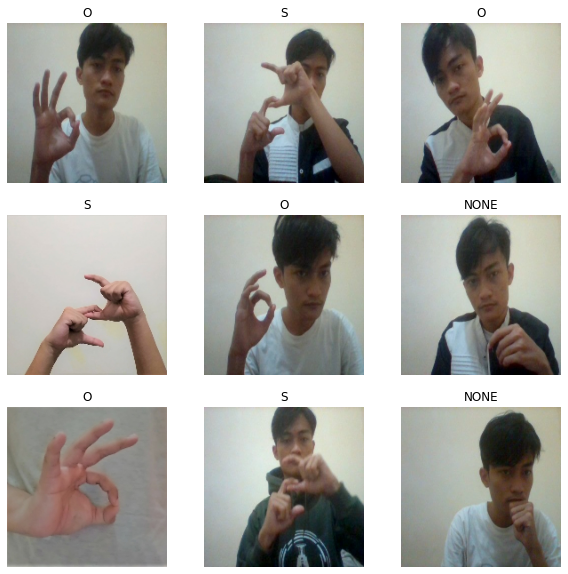

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
from tensorflow.keras import layers

normalization_layer = layers.Rescaling(1./255)

In [19]:
import numpy as np

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.002723335 0.8795207


In [28]:
from tensorflow.keras.models import Sequential

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes)
])

tf.keras.backend.clear_session()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
# Create Model
size_img = (img_height, img_width, 3)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D

num_classes = len(class_names)

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=size_img))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

tf.keras.backend.clear_session()

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [31]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
3/3 [==============================] - 5s 2s/step - loss: 1.4103 - accuracy: 0.3837 - val_loss: 0.9853 - val_accuracy: 0.3810
Epoch 2/15
3/3 [==============================] - 2s 930ms/step - loss: 1.1068 - accuracy: 0.3721 - val_loss: 1.0180 - val_accuracy: 0.3810
Epoch 3/15
3/3 [==============================] - 2s 804ms/step - loss: 1.0651 - accuracy: 0.4302 - val_loss: 1.0880 - val_accuracy: 0.3333
Epoch 4/15
3/3 [==============================] - 2s 817ms/step - loss: 1.0247 - accuracy: 0.6628 - val_loss: 1.0617 - val_accuracy: 0.3810
Epoch 5/15
3/3 [==============================] - 2s 937ms/step - loss: 0.9553 - accuracy: 0.7093 - val_loss: 0.9606 - val_accuracy: 0.5238
Epoch 6/15
3/3 [==============================] - 3s 828ms/step - loss: 0.8635 - accuracy: 0.6279 - val_loss: 0.8512 - val_accuracy: 0.4762
Epoch 7/15
3/3 [==============================] - 2s 806ms/step - loss: 0.6797 - accuracy: 0.8372 - val_loss: 0.6595 - val_accuracy: 0.7143
Epoch 8/15
3/3 [=======

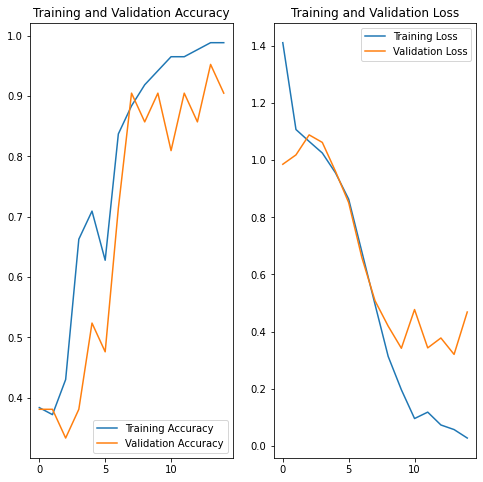

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
model.save('/content/drive/MyDrive/Model_dis_2/model_baru.h5')

# Using Augmentation

In [30]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

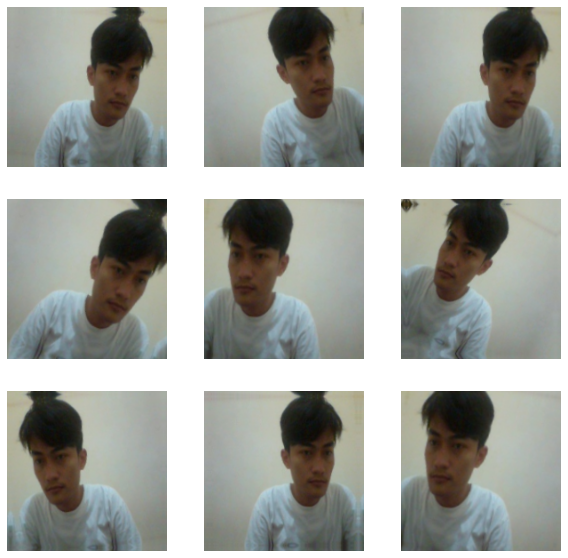

In [31]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [32]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [35]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
3/3 [==============================] - 4s 1s/step - loss: 2.2897 - accuracy: 0.3837 - val_loss: 1.5023 - val_accuracy: 0.5238
Epoch 2/15
3/3 [==============================] - 3s 1s/step - loss: 1.4500 - accuracy: 0.2558 - val_loss: 1.2724 - val_accuracy: 0.0952
Epoch 3/15
3/3 [==============================] - 3s 953ms/step - loss: 1.1760 - accuracy: 0.3256 - val_loss: 1.1365 - val_accuracy: 0.0952
Epoch 4/15
3/3 [==============================] - 3s 930ms/step - loss: 1.0972 - accuracy: 0.3256 - val_loss: 1.1237 - val_accuracy: 0.2381
Epoch 5/15
3/3 [==============================] - 4s 2s/step - loss: 1.0820 - accuracy: 0.4302 - val_loss: 1.1180 - val_accuracy: 0.3810
Epoch 6/15
3/3 [==============================] - 3s 1s/step - loss: 1.0732 - accuracy: 0.4070 - val_loss: 1.0906 - val_accuracy: 0.3810
Epoch 7/15
3/3 [==============================] - 3s 1s/step - loss: 1.0687 - accuracy: 0.4070 - val_loss: 1.0427 - val_accuracy: 0.7143
Epoch 8/15
3/3 [===================

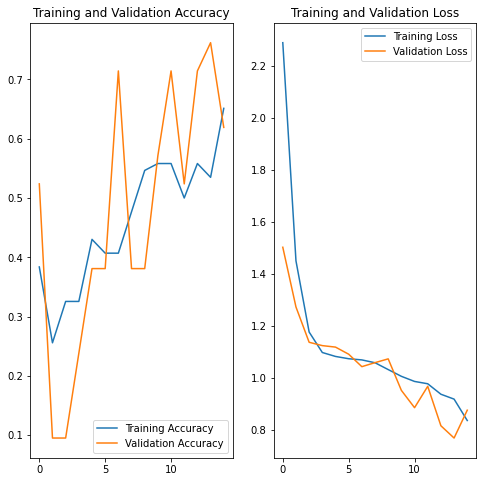

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Test Image

In [39]:
dirpath = '/content/drive/MyDrive/SOS/S/WIN_20220724_06_24_15_Pro.jpg'
model = tf.keras.models.load_model('/content/drive/MyDrive/Model_dis_2/model_baru.h5')
img = tf.keras.utils.load_img(
    dirpath, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to S with a 95.19 percent confidence.


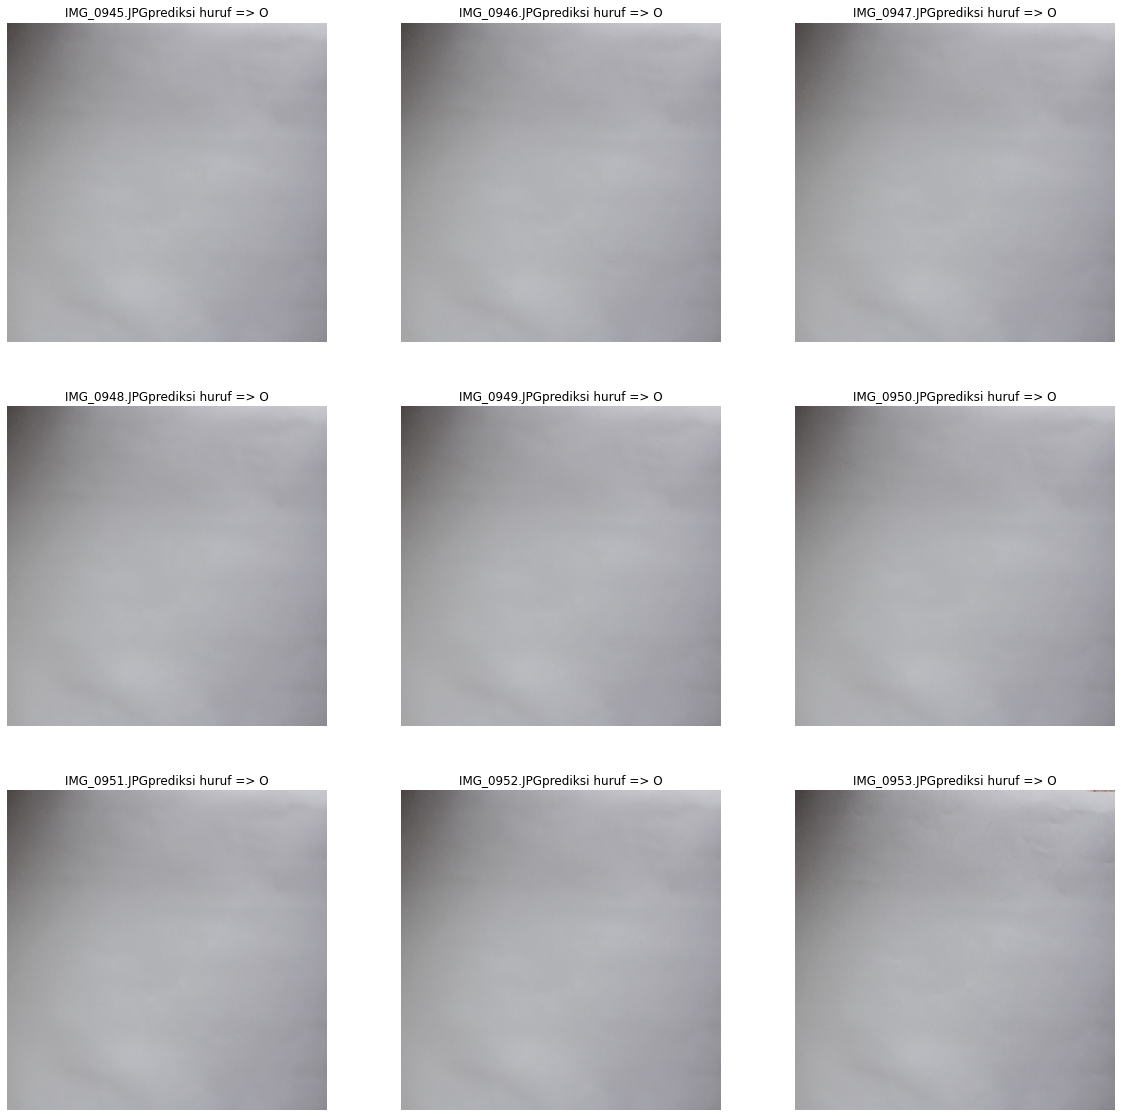

In [66]:
# Test image in folder 'test'

size_img = (img_height, img_width, 3)

from keras.preprocessing import image
import numpy as np
import os
directory = '/content/drive/MyDrive/Citra BISINDO/NOTHING'
name_class = ['NONE', 'O', 'S']
image_name = []
images = []
collect_img = []
count_img = 9
list_file = sorted(os.listdir(directory))
model = tf.keras.models.load_model('/content/drive/MyDrive/Model_dis_2/model_baru.h5')

for img in list_file[:count_img]:
    image_name.append(img)
    img = os.path.join(directory, img)
    img = image.load_img(img, target_size=(size_img))
    img_np = image.img_to_array(img)
    img = np.expand_dims(img_np, axis=0)
    images.append(img)
    collect_img.append(img_np)

images = np.vstack(images)
classes = model.predict(images)

plt.figure(figsize=(20, 20))
for i in range(len(list_file[:count_img][:count_img])):
    idX_class = classes[i]
    ax = plt.subplot(3, 3, i + 1)

    if np.argmax(idX_class) == 0:
      # print(i+1, image_name[i],'    ', name_class[0])
      plt.imshow(collect_img[i].astype("uint8"))
      plt.title(image_name[i]+'prediksi huruf => '+name_class[0])
      plt.axis("off")

    elif np.argmax(idX_class) == 1:
      # print(i+1, image_name[i],'    ', name_class[1])
      plt.imshow(collect_img[i].astype("uint8"))
      plt.title(image_name[i]+'prediksi huruf => '+name_class[1])
      plt.axis("off")
      
    elif np.argmax(idX_class) == 2:
      # print(i+1, image_name[i],'    ', name_class[2])
      plt.imshow(collect_img[i].astype("uint8"))
      plt.title(image_name[i]+'prediksi huruf => '+name_class[2])
      plt.axis("off")